In [13]:
from ScriptFiles import DataCleaning_and_Prediction as dc
from ScriptFiles import DataRead_and_PreClean as dr
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import datetime as dt
from ipywidgets import *
from IPython.display import display
desired_width = 360
pd.set_option('display.width', desired_width)
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
</style>
"""))
 

In [14]:
#############################################################################
### Function to plot Data profile in terms of fuelvoltage, Distance over time

def plotData_profiles(df):
    plt.rcParams['figure.figsize'] = [16, 12]

    #### 1. Checking order of Data, as per datetime
    plt.subplot(3,1,1)
    plt.plot(df.index, df.datetime, 'g.', markersize=1, linewidth=1);

    plt.subplot(3,1,2)
    plt.plot(df.index, df.fuelVoltage, 'g.', markersize=2, linewidth=1);

    plt.subplot(3,1,3)
    plt.plot(df.index, df.distance, 'g-', markersize=2, linewidth=1);
    plt.title("Cumulative Distance vs Time", fontsize=15)
    plt.show()

In [15]:
#######################################################
### Function to Plot theft Points over Cleaned Data

def plot_theftpts(cleanedDf , theftpts=[], refPts=[], xlim=[], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize'] = [16,4]
    # plt.subplot(6,1,1)
    fig, ax1 = plt.subplots()
    ax1.plot(cleanedDf.index, cleanedDf.fuelVoltage, 'g.', markersize=2, linewidth=1)
    ax1.set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('FuelVoltage', color='b')
    ax1.tick_params('y', colors='b')
    if len(ylim1)!=0:
        ax1.set_ylim(ylim1)

    ax2 = ax1.twinx()
    ax2.plot(cleanedDf.index, cleanedDf.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        ax2.set_ylim(ylim2)
    plt.title("Initial Prediction theft Points - ZOOMED")
    if len(xlim) !=0:
        plt.xlim(xlim)
    
    for pt in theftpts:
        ax1.axvline(pt, color = 'black')
        
    for pt in refPts:
        ax1.axvline(pt, color = 'Red')
    plt.show()


In [16]:
def plot_Results(df, df_clean, result_df, theftpts=[], refPts=[], xlim = [], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize']=[16,12]
    fig, axi = plt.subplots(4, 1)
    axi[0].plot(df.datetime, df.fuelVoltage, 'g.', markersize=1, linewidth=1);
    #plt.plot(df.datetime, df.distance, 'b-', markersize=1, linewidth=1);
    axi[0].set_title('Original FuelData vs Time')
    axi[0].set_xlabel('time')

    axi[1].plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    axi[1].set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    axi[1].set_ylabel('FuelVoltage', color='b')
    axi[1].tick_params('y', colors='b')
    if len(ylim1) != 0:
        axi[1].set_ylim(ylim1)

    ax2 = axi[1].twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2) != 0:
        ax2.set_ylim(ylim2)
    if len(xlim) != 0:
        plt.xlim(xlim)
    axi[1].set_title('Cleaned Data')
        
    for pt in refPts:
        axi[1].axvline(pt, color = 'Red')
    
    
    
    axi[2].plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    axi[2].set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    axi[2].set_ylabel('FuelVoltage', color='b')
    axi[2].tick_params('y', colors='b')
    if len(ylim1)!=0:
        axi[2].set_ylim(ylim1)

    ax2 = axi[2].twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        axi[2].set_ylim(ylim2)
        
    if len(xlim) !=0:
        plt.xlim(xlim)
    plt.title('Final Predicted Theft Pts - ZOOMED')

    for pt in result_df.theft_index:
        plt.axvline(pt, color = 'black')
        

    axi[3].plot(result_df.theft_index, result_df['fuel_VoltageJump'], 'g-', markersize=3, linewidth=1);
    axi[3].set_title('Fuel/km Ratio at Predicted theft pts - ZOOMED')
    
    axi[3].set_xlabel('time index')
    
    fig.tight_layout()

#     if len(xlim) !=0:
#         plt.xlim(xlim)
#     if len(ylim)!=0:
#         plt.ylim(ylim)

    #plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);

    plt.show()

In [17]:
def findMax_decayRate(cleanDf):

    i = 0
    dt = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/500
    avgDT = []
    indexlst = []
    dist = cleanDf.distance[i] - cleanDf.distance[0]
    while (i<len(cleanDf)) and (dist <= 5000): 
        df = 0
        dist = 0.001*(cleanDf.distance[i] - cleanDf.distance[0])
        print(dist)
        dfRef = cleanDf.fuelVoltage[i]
        dsRef = cleanDf.distance[i]
        while (df<=dt  and i<len(cleanDf)):
            df = dfRef - cleanDf.fuelVoltage[i] 
            if df <0 :
                dfRef = cleanDf.fuelVoltage[i]
            i+=1
            #print(i)

        if i<len(cleanDf):
            ds = cleanDf.distance[i] - dsRef
            if df>0 :
                #print (i)
                if ds==0:
                    ds = df/1000
                    #print("df = ",df,"****",i)
                avg = df/ds
                avgDT.append(avg)
                indexlst.append(cleanDf.index[i])

    med = pd.Series(avgDT).median()
    mean = pd.Series(avgDT).mean()
    avg = pd.Series(avgDT)
    max_dCRate = avg.median()+ 3*(abs(avg - avg.median()).median())
        
    return pd.Series(avgDT), indexlst, 1000*max_dCRate


In [18]:
i=j=0
while (i<10) and j<3 :
    print (i,j)
    i+=1
    j+=1

0 0
1 1
2 2


In [19]:
#####################################################################
### Function to generate FuelMaxVoltage & FuelMinVoltage, to be sent
### to the main devices database for records.
def Gen_FuelMaxMin(df):
    df = dr.perform_PreFormating(df)
    dff, dff2 = dr.perform_postFormating(df)

    y_smooth = sp.signal.medfilt(dff.fuelVoltage, 99)
    fmax = max(y_smooth)
    fmin = min(y_smooth)
    #df_clean = dc.Clean_NoiseData(dff, fmax, fmin, 0)

    return fmax, fmin


In [20]:
folderpath = r"H:\Analytics\FuelAnalysis\test2"
savePath = r"H:\Analytics\FuelAnalysis\results"
filepath = r""
df_list = []
filesname = dr.read__MultipleCSVs(folder_path= folderpath, nfiles=8)
for file in filesname:
    df = dr.read_SingleCSV(file)
    df_list.append(df)

ctr = 0
def formatDf(df):
    #df_list[0].info()
    df = dr.perform_PreFormating(df)
    print ("Dataset_"+str(ctr+1) + "Preformatting Done")

    dff, dff2 = dr.perform_postFormating(df)
    print("Dataset_" + str(ctr + 1) + " Postformatting Done")
    return dff,dff2

def cleanDF(dff, fuelMax, fuelMin, neb_ds):
    df_clean = dc.Clean_NoiseData(dff, fuelMax, fuelMin, neb_ds)
    print("Dataset_" + str(ctr + 1) + " Data Cleaning Done")
    return df_clean

def findtheft(df_clean, fuelMax, fuelMin, neb_dst):
    theft_pts, refpts = dc.jump_point(df_clean, 0.01, fuelMax, fuelMin, neb_dst)
    print("Dataset_" + str(ctr + 1) + " Theft & Refuel points Indentified")
    return theft_pts, refpts

    

H:\Analytics\FuelAnalysis\test2\cordinates_007042639339.csv
H:\Analytics\FuelAnalysis\test2\cordinates_007042640749.csv
H:\Analytics\FuelAnalysis\test2\cordinates_007042641148.csv
H:\Analytics\FuelAnalysis\test2\cordinates_007042644259.csv
H:\Analytics\FuelAnalysis\test2\cordinates_007042647584.csv


C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


H:\Analytics\FuelAnalysis\test2\cordinates_007042648443.csv
H:\Analytics\FuelAnalysis\test2\cordinates_008527256951.csv
H:\Analytics\FuelAnalysis\test2\cordinates_008527904085.csv
H:\Analytics\FuelAnalysis\test2\cordinates_008527948598.csv


In [21]:
#plotData_profiles(df)
df = df_list[1]
df = df[:]
df = df.reset_index(drop= True)
df.st = df.io_state.apply(lambda x: str(x)[1])
dis = df[df.st == '0'].distance.apply(lambda x: int(x))

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


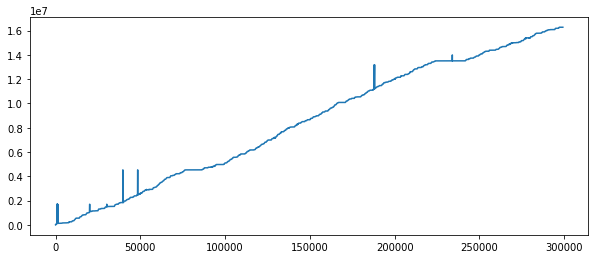

In [22]:
plt.rcParams['figure.figsize'] = [10,4]
plt.plot(dis);

In [23]:
fuelMax, fuelMin = Gen_FuelMaxMin(df)

299150
66076
LenPostFormating:  66076


In [24]:
fuelMax, fuelMin

(528.0, 164.0)

In [25]:
dff, dff2 = formatDf(df.copy())
Dmax = dff.distance.max()

Dataset_1Preformatting Done
299150
66076
LenPostFormating:  66076
Dataset_1 Postformatting Done


In [26]:
df = dr.perform_PreFormating(df)

In [27]:
d = df[df.dev_state=='0']
len(d[d.fuelVoltage <= 5])

9184

In [28]:
len(df[df.dev_state=='0'])

229800

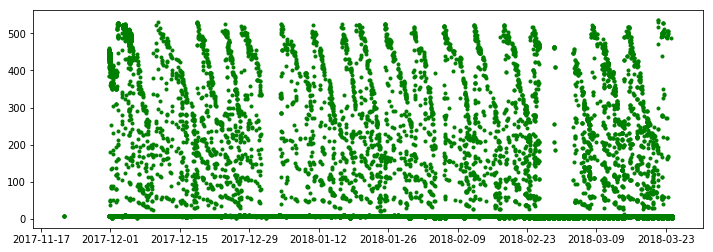

In [29]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(df[df.dev_state=='0'].datetime, df[df.dev_state=='0'].fuelVoltage, 'g.');
#plt.ylim(0,8)

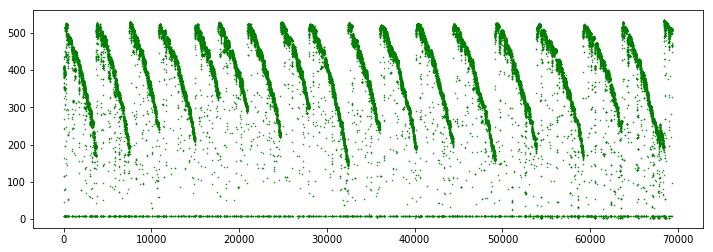

In [30]:
%matplotlib inline
df= df[df.dev_state=='1'].reset_index(drop = True)
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(df.index, df.fuelVoltage, 'g.', markersize = 1);

In [31]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66076 entries, 0 to 66075
Data columns (total 7 columns):
datetime       66076 non-null datetime64[ns]
lat            66076 non-null object
long           66076 non-null object
speed          66076 non-null float64
distance       66076 non-null float64
fuelVoltage    66076 non-null float64
dev_state      66076 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 3.5+ MB


In [32]:
len(dff), len(dff2)

(66076, 69350)

In [33]:
a=[1,2,3,4,5,6]
a[0]

1

In [34]:
dff3 = dff2[dff2.fuelVoltage<=200]

In [35]:
dff.loc[0,'datetime'] - dff.loc[len(dff)-1,'datetime']

Timedelta('-114 days +14:59:24')

In [36]:
dff2.loc[0,'datetime'] - dff.loc[0,'datetime']

Timedelta('-1 days +23:59:16')

In [37]:
dff2.loc[0,'datetime'] - dff.datetime.min()

Timedelta('-1 days +23:59:16')

In [38]:
dff2.datetime[:10]

0   2017-11-30 17:42:33
1   2017-11-30 17:43:17
2   2017-11-30 17:43:46
3   2017-11-30 17:44:17
4   2017-11-30 17:44:24
5   2017-12-01 10:18:14
6   2017-12-01 10:18:44
7   2017-12-01 10:19:14
8   2017-12-01 10:19:45
9   2017-12-01 10:20:15
Name: datetime, dtype: datetime64[ns]

In [39]:

dff.datetime[0]

Timestamp('2017-11-30 17:43:17')

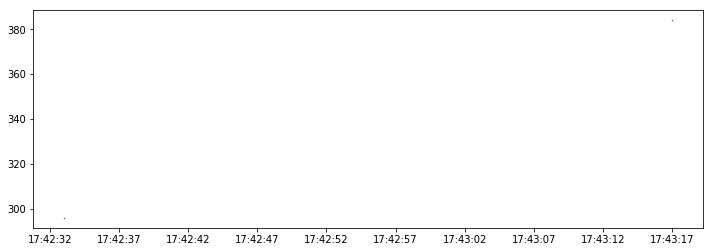

In [55]:
%matplotlib inline
dff2= dff2[dff2.dev_state==1].reset_index(drop=True)
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(dff2[dff2.datetime<=dff.datetime.min()].datetime, dff2[dff2.datetime<=dff.datetime.min()].fuelVoltage,'g.', markersize = 1);
#plt.xlim(0,20000)



3.0

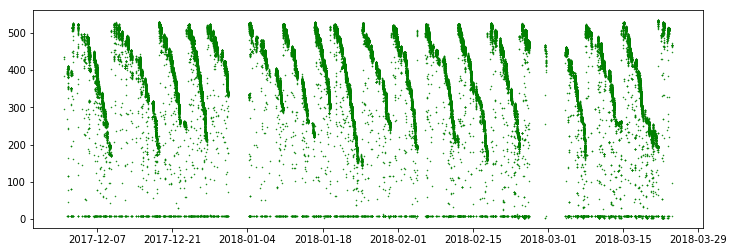

In [56]:

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(dff2.datetime, dff2.fuelVoltage,'g.', markersize = 1);
#plt.xlim(0,30000)
(dff3.fuelVoltage.min())


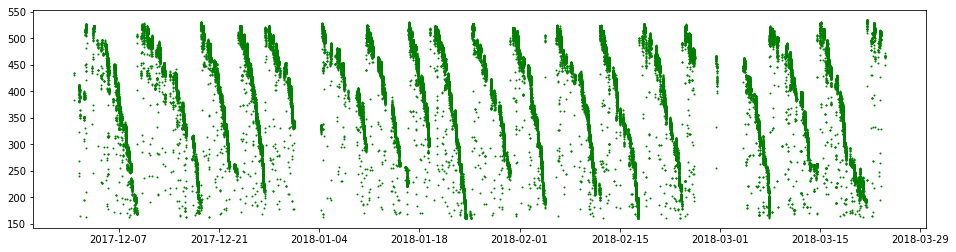

In [57]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dff.datetime, dff.fuelVoltage, 'g.', markersize = 2)
#plt.ylim(2,4)
#plt.xlim(32000,38000)

In [58]:
dff.fuelVoltage.median()

412.0

In [59]:
dff.fuelVoltage.std()

94.2134877291852

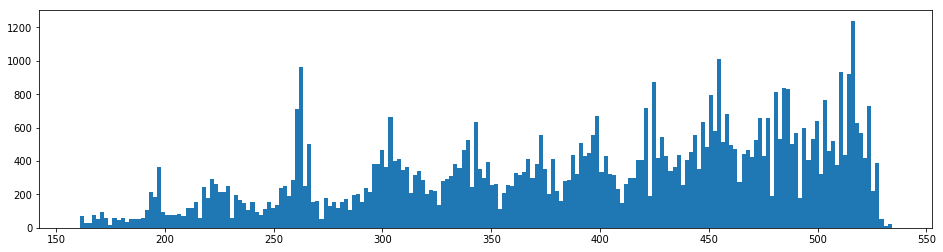

In [60]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,4]
plt.hist(dff.fuelVoltage,200);
#plt.xlim(0,0.02)
#plt.ylim(0,2.5)

In [61]:
np.array([abs(dd) <= 2*dd.std()]).mean()

NameError: name 'dd' is not defined

In [62]:
x = '0'
x.zfill(8)
import time

In [63]:
def Clean_NoiseData2(dff, fuelMax, fuelMin, nds):
    x = pd.Series(dff.index)
    y = pd.Series(dff.fuelVoltage)
        
    ## Neighbourhood Distance
    Nds = 0.01*(fuelMax - fuelMin)
    if nds:
        Nds = nds
    print(Nds)

    
    dff['dd00000'] = abs(y - y.shift(6))
    dff['dd0000'] = abs(y - y.shift(5))
    dff['dd000'] = abs(y - y.shift(4))
    dff['dd00'] = abs(y - y.shift(3))
    dff['dd0'] = abs(y - y.shift(2))
    dff['dd1'] = abs(y - y.shift(1))
    dff['dd2'] = abs(y - y.shift(-1))
    dff['dd3'] = abs(y - y.shift(-2))
    dff['dd4'] = abs(y - y.shift(-3))
    dff['dd5'] = abs(y - y.shift(-4))
    dff['dd6'] = abs(y - y.shift(-5))
    dff['dd7'] = abs(y - y.shift(-6))
    dff['dd8'] = abs(y - y.shift(-7))
    
    dforward = pd.DataFrame()
    dbackward = pd.DataFrame()
    for i in range(1,10):
        dforward['d'+str(i)] = abs(y - y.shift(i))
        dbackward['d'+str(i)] = abs(y - y.shift(-1*i))
    dbackward = dbackward.fillna(0)
    dforward = dforward.fillna(0)
    
    dff2 = dff[(dforward.d1 <= Nds) & (dbackward.d1 <= Nds) & (dforward.d2 <= 2*Nds) & (dbackward.d2 <= 2*Nds) &
               (dforward.d3 <= 3*Nds) & (dbackward.d3 <= 3*Nds) & (dforward.d4 <= 4*Nds) & (dbackward.d4 <= 4*Nds) &
               (dforward.d5 <= 5*Nds) & (dbackward.d5 <= 5*Nds) & (dforward.d6 <= 6*Nds) & (dbackward.d6 <= 6*Nds) &
               (dforward.d7 <= 7*Nds) & (dbackward.d7 <= 7*Nds) & (dforward.d8 <= 8*Nds) & (dbackward.d8 <= 8*Nds)]
    dff2 = dff2.reset_index(drop = True)
    

    p = dff['dd1']
    ## Removing Error Data
    dff1 = dff[(dff.dd1 <= Nds) & (dff.dd2 <= Nds) & (dff.dd0 <= 2*Nds) & (dff.dd3 <= 2*Nds) &
               (dff.dd00 <= 3*Nds) & (dff.dd4 <= 3*Nds) & (dff.dd000 <= 4*Nds) & (dff.dd5 <= 4*Nds) &
               (dff.dd0000 <= 5*Nds) & (dff.dd6 <= 5*Nds) & (dff.dd00000 <= 6*Nds) & (dff.dd7 <= 6*Nds)]
    dff1 = dff1.reset_index(drop=True)  ## Reseting index
    #print (dff1[['dd1','dd0','dd00','dd000','dd0000','dd00000']].head(40))

    # plt.rcParams['figure.figsize'] = [16, 4]
    # plt.plot(p, 'b.')
    # plt.title('Histogram - Consecutive Fuel Difference ', fontsize=15)
    # plt.ylim(0, 0.05)
    #
    # #     plt.ylim(0.02,1)
    # #     plt.savefig("test.png")
    # plt.rcParams['figure.figsize'] = [16, 4]
    # plt.plot(dff.index[:], dff.fuelVoltage[:], 'g.', markersize=2, linewidth=1);
    # plt.ylim(0, 1.1)
    dfClean = dff1[['datetime','lat', 'long','speed','distance','fuelVoltage']]
    dfClean['fuelVoltage_Percent'] = dfClean.fuelVoltage.apply(lambda x: round((100*x/(fuelMax - fuelMin)),2))
    dfClean2 = dff2[['datetime','lat', 'long','speed','distance','fuelVoltage']]
    dfClean2['fuelVoltage_Percent'] = dfClean2.fuelVoltage.apply(lambda x: round((100*x/(fuelMax - fuelMin)),2))

    return dfClean, dfClean2

In [65]:
import time
strttime = time.time()
dfcln, dfcln2 = Clean_NoiseData2(dff.copy(), fuelMax, fuelMin,2*meddev)
print(time.time()-strttime)

NameError: name 'meddev' is not defined

In [66]:
y = pd.Series([1,2,3,4,5,6,7,8])
y.shift(-1) -y

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    NaN
dtype: float64

In [67]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dfcln2.index, dfcln2.fuelVoltage,  'g.', markersize = 1)
#plt.ylim(300,580)
plt.xlim(0,8000)
plt.savefig("cleanf22.png")

NameError: name 'dfcln2' is not defined

In [68]:
df_clean = dff

In [69]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal
 
t = np.linspace(0,10,200) # create a time signal
x1 = np.sin(t) # create a simple sine wave
x2 = x1 + np.random.rand(200) # add noise to the signal

def f(x):
    y1 = sp.signal.medfilt(df_clean.fuelVoltage,x) # add noise to the signal
    # plot the results
    plt.subplot(2,1,1)
    plt.plot(df_clean.index,df_clean.fuelVoltage,'g.', markersize = 1)
    plt.title('input wave')
    plt.xlabel('time')
    plt.xlim(10000, 30000)
    plt.subplot(2,1,2)
    plt.plot(df_clean.index,y1,'g.', markersize = 1)
    plt.title('filtered wave')
    plt.xlabel('time')
    plt.xlim(10000, 30000)
    plt.show()
interact(f, x= IntSlider(min=1, max=200, step=2,value=99));

interactive(children=(IntSlider(value=99, description='x', max=200, min=1, step=2), Output()), _dom_classes=('…

In [70]:
y1 = sp.signal.medfilt(df_clean.fuelVoltage,99) 
len(df_clean), len(y1)

(66076, 66076)

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


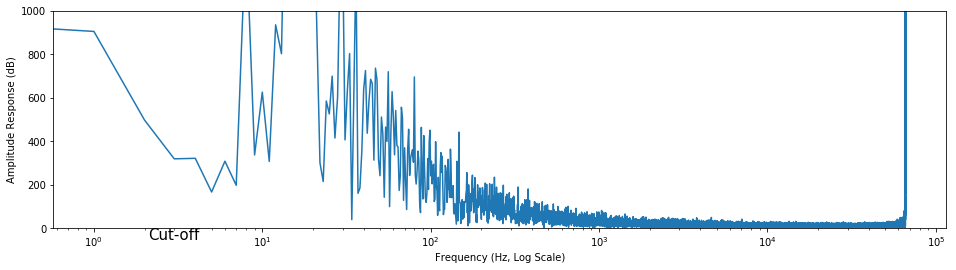

In [71]:
from scipy.fftpack import fft
from scipy import signal as sg
import statsmodels.api as sm
from scipy.signal import butter, lfilter, freqz
import datetime

normdata = df_clean.fuelVoltage/df_clean.fuelVoltage.max()
yvolt = fft(df_clean.fuelVoltage/df_clean.fuelVoltage.max())

plt.rcParams['figure.figsize'] = [16,4]
plt.ylim(0,1000);
plt.plot(np.abs(yvolt[:]));
plt.rcParams['figure.figsize'] = [16,4]
plt.xscale('log')
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (Hz, Log Scale)')
#plt.axvline((2.5, color = 'black')
plt.text(2.1,-50, "Cut-off", fontsize = 15);

def butter_lowpass_filter(data, cutoff, fs, order=5, ftype = False):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=ftype)
    y = lfilter(b, a, data)
    y1 = sg.filtfilt(b,a, data)
    return y


# Filter the data, and plot both the original and filtered signals.
fs = 500             # Sampling Frequency
order = 5             # Order of Filter
cutoff = 10          # Filter Cut-off Frequency

df = df_clean.copy()
# Calling Butterworth filter
y2 = df_clean.fuelVoltage.max() *(butter_lowpass_filter(normdata, cutoff, fs, order, ftype= False))
time = df.datetime

(0, 12000)

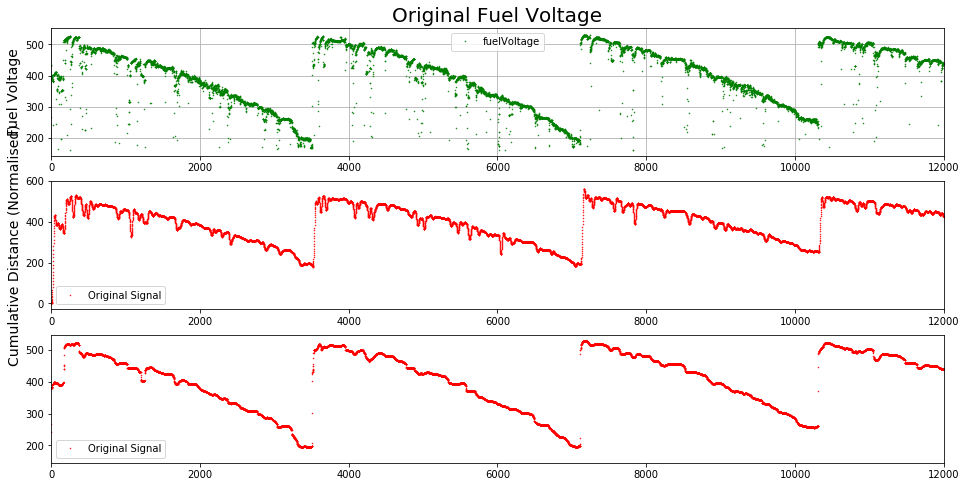

In [72]:
#Plotting Results
plt.rcParams['figure.figsize'] = [16,8]

plt.subplot(3, 1,1)
#plt.plot(time, norm_data, 'b-', linewidth=1, label='Original Signal')
plt.plot(df.index, df.fuelVoltage, 'g.', markersize = 1, linewidth = 1)
plt.legend()
plt.grid()
plt.ylabel('Fuel Voltage',  fontsize = 14)
plt.xlim(0,12000)
plt.title('Original Fuel Voltage', fontsize = 20)
#plt.ylim(df_clean.fuelVoltage.min(), 1.05*df_clean.fuelVoltage.max())
#plt.axvline(60000, color = 'black')

plt.subplot(3, 1,2)
plt.plot(df.index, y2, 'r.', markersize=1, label='Original Signal')
plt.legend()
plt.xlim(0,12000)
#plt.ylim(df_clean.fuelVoltage.min(), 1.05*df_clean.fuelVoltage.max())
plt.ylabel('Cumulative Distance (Normalised)',  fontsize = 14)
#plt.xlim(datetime.datetime(2018,1,27,2,0), datetime.datetime(2018,2,15,6,55))
plt.subplot(3, 1,3)
plt.plot(df_clean.index, y1, 'r.', markersize=1, label='Original Signal')
plt.legend()
plt.xlim(0,12000)

#plt.tight_layout()

In [73]:
#df_clean = cleanDF(dff.copy(), fuelMax, fuelMin,0)

In [74]:
df_clean2 = dff.copy()
df_clean2.fuelVoltage = pd.Series(y1)

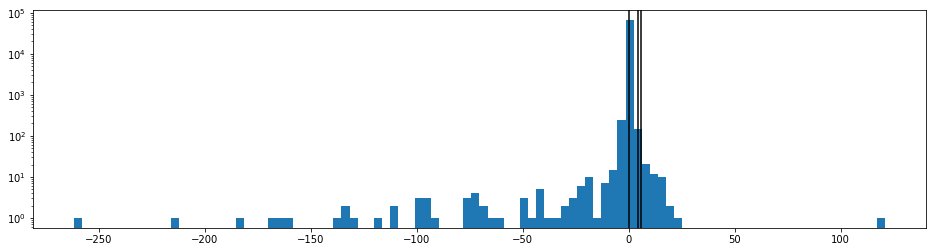

In [75]:
def avg_NeigbourDistance(dff):
    dd = dff.fuelVoltage - dff.fuelVoltage.shift(-1)  
    dd = dd.dropna()
    #print(dd
    plt.rcParams['figure.figsize'] = [16,4]

    plt.hist(dd, bins=100)
    plt.axvline(dd.median(), color = 'black')
    plt.axvline(2*dd.std(), color = 'black')
    plt.axvline(1.5*dd.std(), color = 'black')
    plt.semilogy()
    return dd
dd = avg_NeigbourDistance(df_clean2)

In [76]:
dd2 = dd[abs(dd - dd.median()) < 2*dd.std()]
meddev = abs(dd2 - dd2.median()).median()
meddev2 = abs(dd2 - dd2.median()).mean()
print (dd.mean(), dd.median(),2*meddev, 2*meddev2, 2*dd2.std(), 0.01*(fuelMax - fuelMin), 0.01*(fuelMax - 0.05*fuelMax))

-0.001331819901626939 0.0 0.0 0.23695546656959107 0.798022667872249 3.64 5.016


In [77]:
distDF = pd.DataFrame(columns=['mean','median','2*Meddev','2*std','MaxMin','MaxMin0'])
distDF.loc[0] = [dd.mean(), dd.median(),2*meddev, 2*dd.std(), 0.01*(fuelMax - fuelMin), 0.01*(fuelMax - 0.05*fuelMax)]
distDF

,mean,median,2*Meddev,2*std,MaxMin,MaxMin0
0,-0.001332,0.0,0.0,5.648575,3.64,5.016


C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


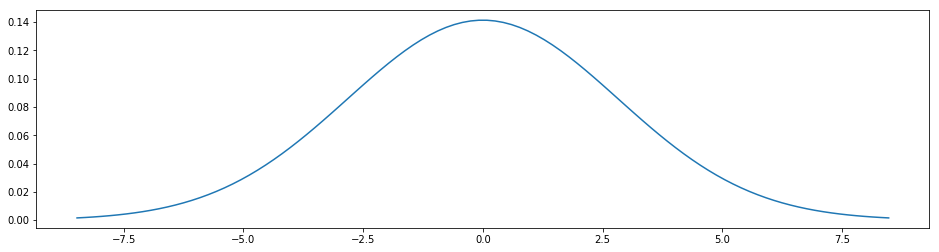

In [78]:
import matplotlib.mlab as mlab
mu = dd.mean()
#variance = (dff.fuelVoltage.std())*(dff.fuelVoltage.std())
sigma = dd.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(x,mlab.normpdf(x, mu, sigma))

In [80]:
dd[dd > 2*dd.std()]

368        6.0
376       17.0
1024      13.0
1204       8.0
1205       8.0
1206       7.0
1655       6.0
3233      10.0
3955       8.0
11053     12.0
11475      9.0
11638      6.0
14939     15.0
15610      7.0
15886     12.0
17049     19.0
17511     11.0
20438     13.0
20663      9.0
21115      8.0
24133     18.0
24973      7.0
28569     15.0
31469     17.0
32031     13.0
32219      6.0
32563      6.0
35149      6.0
35937     13.0
39189      7.0
         ...  
43158     10.0
44270      7.0
46064      8.0
47622      6.0
47623     15.0
48157      7.0
48980      7.0
52062      6.0
52104      8.0
53761     14.0
53778      9.0
54381      6.0
57207      6.0
57448      6.0
57450     16.0
57821     15.0
59527      7.0
60885     12.0
61276      6.0
61277     14.0
61295      6.0
61531      9.0
62313      7.0
65231     14.0
65689      7.0
66057      7.0
66060     24.0
66061      6.0
66073     12.0
66074    121.0
Name: fuelVoltage, Length: 61, dtype: float64

In [81]:
a = dd.value_counts()
dd[dd != 0].median()

1.0

In [82]:
dd.mean(), dd.median(), dd.std()

(-0.001331819901626939, 0.0, 2.8242875593563723)

In [83]:
## Finding avgMax decay rate
avgDT, indexlst, max_dCRate = findMax_decayRate(df_clean2)

0.0
131.57
131.57
131.57
131.57
131.729
132.466
132.466
132.466
157.43200000000002
163.35
173.946
174.32500000000002
174.32500000000002
174.32500000000002
255.829
255.834
255.834
255.871
256.43
257.778
259.689
374.765
375.753
386.257
386.668
389.24
401.176
404.606
405.469
408.25
410.563
412.35
412.90000000000003
417.248
418.426
419.933
425.254
428.065
432.216
439.639
442.43600000000004
443.03700000000003
444.962
447.17400000000004
450.812
453.742
455.884
456.567
456.886
457.319
457.319
457.842
459.35200000000003
459.461
459.61400000000003
459.757
494.57
503.8
504.535
506.048
507.349
507.492
536.595
537.1560000000001
538.073
542.646
544.215
547.449
548.26
556.4590000000001
556.4590000000001
556.4590000000001
556.4590000000001
556.4590000000001
591.373
592.837
594.316
596.795
598.491
599.463
600.825
600.897
600.927
603.973
607.09
608.711
609.705
613.891
614.587
615.328
617.537
623.1370000000001
632.328
633.202
635.106
635.538
642.61
656.337
671.16
672.53
673.948
676.053
676.442
677.552
6

4515.557
4522.483
4524.868
4530.763
4577.771
4579.362
4580.05
4580.6140000000005
4599.52
4601.021
4601.506
4603.895
4604.377
4605.683
4605.829
4606.363
4634.611
4639.572
4640.342
4642.78
4645.095
4648.568
4651.169
4653.075
4655.446
4672.018
4685.545
4689.799
4691.358
4693.133
4695.548
4696.628
4699.1050000000005
4699.945
4700.8460000000005
4703.155
4703.18
4703.204
4703.204
4703.204
4749.664
4749.682
4749.703
4749.712
4749.725
4749.725
4749.725
4749.725
4749.725
4751.058
4751.803
4752.55
4754.894
4755.283
4756.0
4758.198
4759.02
4801.32
4805.976
4807.688
4809.196
4809.558
4812.511
4813.376
4813.376
4813.878
4815.86
4816.3330000000005
4818.777
4820.701
4821.462
4823.256
4823.725
4824.053
4824.072
4824.072
4826.143
4826.798
4827.087
4827.183
4872.976
4876.918
4878.1720000000005
4879.896
4883.081
4892.805
4894.782
4895.974
4896.981
4897.54
4898.738
4900.111
4902.415
4903.791
4904.509
4905.43
4905.56
4906.659
4907.448
4908.2480000000005
4913.506
4919.654
4921.849
4923.729
4923.875
4924.043

In [84]:
max_dCRate, avgDT.median(), round(avgDT.mean(),5)

(2.4343832820837217, 0.0007656967840735069, 40.94014)

In [85]:
max_dCRate2, avgDT2.median(), round(avgDT2.mean(),5)

NameError: name 'max_dCRate2' is not defined

In [86]:

a = int(-3)
if a:
    print (a)

-3


In [87]:
def jump_point2(dff, level = 0.05, fuelMax=100, fuelMin=0):
    x = np.array(dff.index)
    y = np.array(dff.fuelVoltage)
    d = np.array(dff.distance)
    
    #######################################################################
    ## No. of Neighbourhood pts , dependent on sampling Rate of IoT device
    ## Criteria Set = Avg No. of points inside 10Km window will be considered
    n = int(10000/(dff.distance.max()/len(dff)))
    print (n)
    level = level*(fuelMax - fuelMin)
    theft_pts = []
    refpts = []
    rctr = 0
    ctr = 0
    i = 0
    
    for i in range(1, len(x)):
        try:
            #             d1 =abs(y[i+1] - y[i])
            #             d2 =abs(y[i+2] - y[i])
            d_forward = (y[i + 1:i + n] - y[i])
            d_backward = (y[i + 1] - y[i - n:i])
            disfor.append(d[i + n] - d[i])
            disback.append(d[i] - d[i-n])
            # print (d_backward)
            
        except:
            pass
            #print("**")
        # dd1.append(d1)
        # dd2.append(d2)
        # if (d1 >= 0.05) & (d2 >= 0.05)&(d3 >= 0.05)&(d4 >= 0.05)&(d5 >= 0.05)&(d5 >= 0.05):

        ###########################################################################
        #### Finding probable refueling Points
        if ((sum(d_forward > 1 * 3 * level) in list(range(n-1, n+1)))):  # & (sum(d_forward<0.1) == 19)):
            if (sum(d_backward > 1 * 3 * level) in list(range(n-1, n+1))):
                refpts.append(dff.index[i])
                rctr += 1

        ############################################################################
        #### Finding probable theft points
        if ((sum(d_forward < -1 * level) in list(range(n-1, n+1)))):  # & (sum(d_forward<0.1) == 19)):
            if (sum(d_backward < -1 * level) in list(range(n-1, n+1))):
                theft_pts.append(dff.index[i])
                ctr += 1
                # print(theft_pts, ctr)

        if (ctr >= 2):
            if ((theft_pts[ctr - 1] - theft_pts[ctr - 2]) in list(range(1, 6))):
                theft_pts.pop(ctr - 2)
                ctr -= 1
                # print (i)

                # dd1.append(0)
                # dd2.append(0)
    # dff['dd1'] = pd.Series(dd1)
    # dff['dd2'] = pd.Series(dd2)
    refpts = pd.Series(refpts)
    #shift = abs(refpts.shift(-1) - refpts)
    #print(shift)
    #print ((shift[shift <=5]), refpts[shift[shift <=5]]
    
    print(len(theft_pts))
    return theft_pts, refpts

In [88]:
theft_pts, refpts = jump_point2(df_clean2, 0.01, fuelMax, fuelMin)

40
84


In [89]:
def check_refpts_dropList(refpts):
    
    refpts = pd.Series(refpts)
    refdt = pd.DataFrame()
    refdt['refpts'] = refpts
    refdt['shift'] = refpts.shift(-1) - refpts
    refdt ['dist'] = pd.Series(df_clean2.distance[refpts].reset_index(drop= True))
    i = 0
    dropIndexList = []
    while i in range(len(refdt)):
        
        if refdt.loc[i,'shift'] <= 5:
            i+=1
            while (refdt.loc[i,'shift']  <=5) :
                dropIndexList.append(refdt.refpts[i])
                i+=1
        i+=1
    
    refdt['drop'] = refdt.refpts.apply(lambda x: 'Y' if (x in dropIndexList) else 'N')
    refdt = refdt[refdt['drop']=='N'].reset_index(drop=True)
    return refdt, dropIndexList    


ref , drop = check_refpts_dropList(refpts)


In [90]:
ref[ref['drop']=='Y'].reset_index(drop= True)


,refpts,shift,dist,drop


In [91]:
theft_pts, refpts = findtheft(df_clean2, fuelMax, fuelMin,0)

Points per 10Km:  32
84
Dataset_1 Theft & Refuel points Indentified


In [92]:
theft_pts2, refpts2 = findtheft(dfcln2, fuelMax, fuelMin,0)

NameError: name 'dfcln2' is not defined

In [93]:
dff2[dff2.datetime<=df_clean.datetime.min()]

,datetime,lat,long,speed,distance,fuelVoltage,dev_state
0,2017-11-30 17:42:33,21.6106283,82.0531617,0.0,0.0,296.0,1
1,2017-11-30 17:43:17,21.6106417,82.0531733,0.0,0.0,384.0,1


In [94]:
int(10000/(df_clean.distance.max()/len(df_clean2)))

40

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


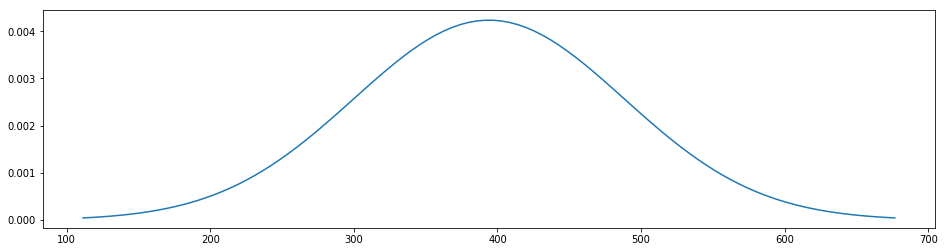

In [95]:
import matplotlib.mlab as mlab
mu = dff.fuelVoltage.mean()
#variance = (dff.fuelVoltage.std())*(dff.fuelVoltage.std())
sigma = dff.fuelVoltage.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(x,mlab.normpdf(x, mu, sigma))

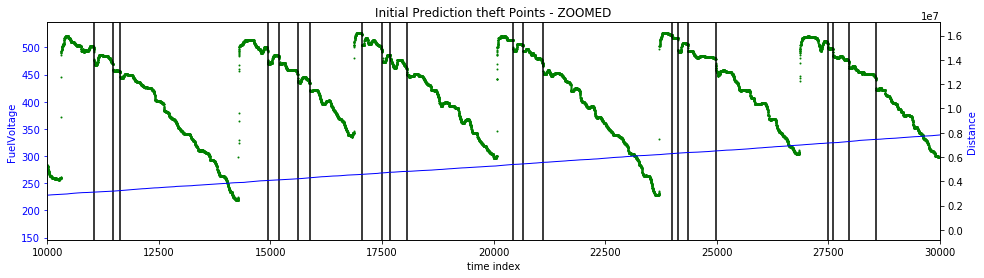

In [96]:
xlim = [10000,30000]
ylim = []
%matplotlib inline
plot_theftpts(df_clean2,refPts=[],theftpts=theft_pts,  xlim = xlim, ylim1= ylim)

In [97]:
xlim = []
ylim = []
%matplotlib inline
plot_theftpts(dfcln2,refPts=[],theftpts=theft_pts2,  xlim = xlim, ylim1= ylim)

NameError: name 'dfcln2' is not defined

In [101]:
len(refpts)

66

In [102]:
df_clean.distance.max() - df_clean.distance[0] 

16277888.0

In [117]:
import time
srt = time.time()
theft_df = dc.generate_TheftTable(df_clean2,theft_pts,max_dCRate, fuelMax, fuelMin)
print (time.time() - srt)

84
0.043998003005981445


In [112]:
def check_refpts_dropList(refdt):

    refdt['shift'] = abs(refdt['refuel_index'].shift(-1) - refdt['refuel_index'])
    #refdt['dist'] = pd.Series(df_clean2.distance[refpts].reset_index(drop=True))
    i = 0
    dropIndexList = []
    while i in range(len(refdt)):

        if refdt.loc[i, 'shift'] <= 5:
            i += 1
            while (refdt.loc[i, 'shift'] <= 5):
                dropIndexList.append(refdt.loc[i,'refuel_index'])
                i += 1
        i += 1

    refdt['drop'] = refdt.refuel_index.apply(lambda x: 'Y' if (x in dropIndexList) else 'N')
    print (len(refdt))
    refdt = refdt[refdt['drop'] == 'N'].reset_index(drop= True)
    return refdt, dropIndexList


def generate_ReFuelTable(df_cleaned, ref_pts, fuelMax, fuelMin):
    refuel_df = pd.DataFrame()
    refuel_df['refuel_index'] = [df_cleaned.index[i] for i in ref_pts]
    refuel_df['lat'] = [df_cleaned.lat[i] for i in ref_pts]
    refuel_df['long'] = [df_cleaned.long[i] for i in ref_pts]
    refuel_df['refuel_time'] = [df_cleaned.datetime[i] for i in ref_pts]

    refuel_df, dropIndex = check_refpts_dropList(refuel_df.copy())
    df_cleaned = df_cleaned.drop(dropIndex)


    for i,j in zip(refuel_df.refuel_index, refuel_df.index):
        success = 0
        pos = 1
        while(success ==0):
            try:
                refuel_df.loc[j,'fuel_VoltageJump'] = (df_cleaned.fuelVoltage[i+pos] - df_cleaned.fuelVoltage[i])
                refuel_df.loc[j,'fuel_VoltageJump(%)'] = 100 * (df_cleaned.fuelVoltage[i+pos] - df_cleaned.fuelVoltage[i]) / (fuelMax - fuelMin)
                refuel_df.loc[j,'dist_jump(KM)'] = (df_cleaned.distance[i + pos] - df_cleaned.distance[i]) * (.001)
                refuel_df.loc[j,'time_jump'] = (df_cleaned.datetime[i + pos] - df_cleaned.datetime[i])
                success =1
            except:
                pos +=1

    refuel_df['fuel_VoltageJump(%)'] = refuel_df['fuel_VoltageJump(%)'].apply(lambda x: round(x,2))

    # result_df.to_csv(r"G:\Analytics\FuelAnalysis\results\reults.csv")

    # plt.plot(result_df.theft_time, result_df.FuelPerKM)
    # plt.semilogy()
    # plt.show()
    print(refuel_df)
    return refuel_df

In [113]:

srt = time.time()
refuel_df = generate_ReFuelTable(df_clean2, refpts, fuelMax, fuelMin)
print (time.time() - srt)

66
    refuel_index                 lat               long         refuel_time   shift drop  fuel_VoltageJump  fuel_VoltageJump(%)  dist_jump(KM) time_jump
0            168  21.281616699999997         82.8367533 2017-12-02 06:56:01     3.0    N              39.0                10.71          0.422  00:00:30
1            175          21.2884983  82.86180829999999 2017-12-02 06:59:32  1081.0    N              22.0                 6.04          0.073  00:00:30
2           1256           21.277245           82.81446 2017-12-06 06:43:52  2252.0    N              22.0                 6.04          0.000  00:00:30
3           3508           21.280665         82.8322833 2017-12-09 15:04:42     1.0    N             194.0                53.30          0.081  00:05:17
4           3510          21.2804217         82.8315183 2017-12-09 15:09:59    15.0    N              23.0                 6.32          0.217  00:00:30
5           3525  21.277233300000002         82.8144233 2017-12-10 03:32:13    

In [114]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(result_df2.theft_index, result_df2['fuel_VoltageJump'], 'g-', markersize=3, linewidth=1);
#plt.ylim(0,400)

NameError: name 'result_df2' is not defined

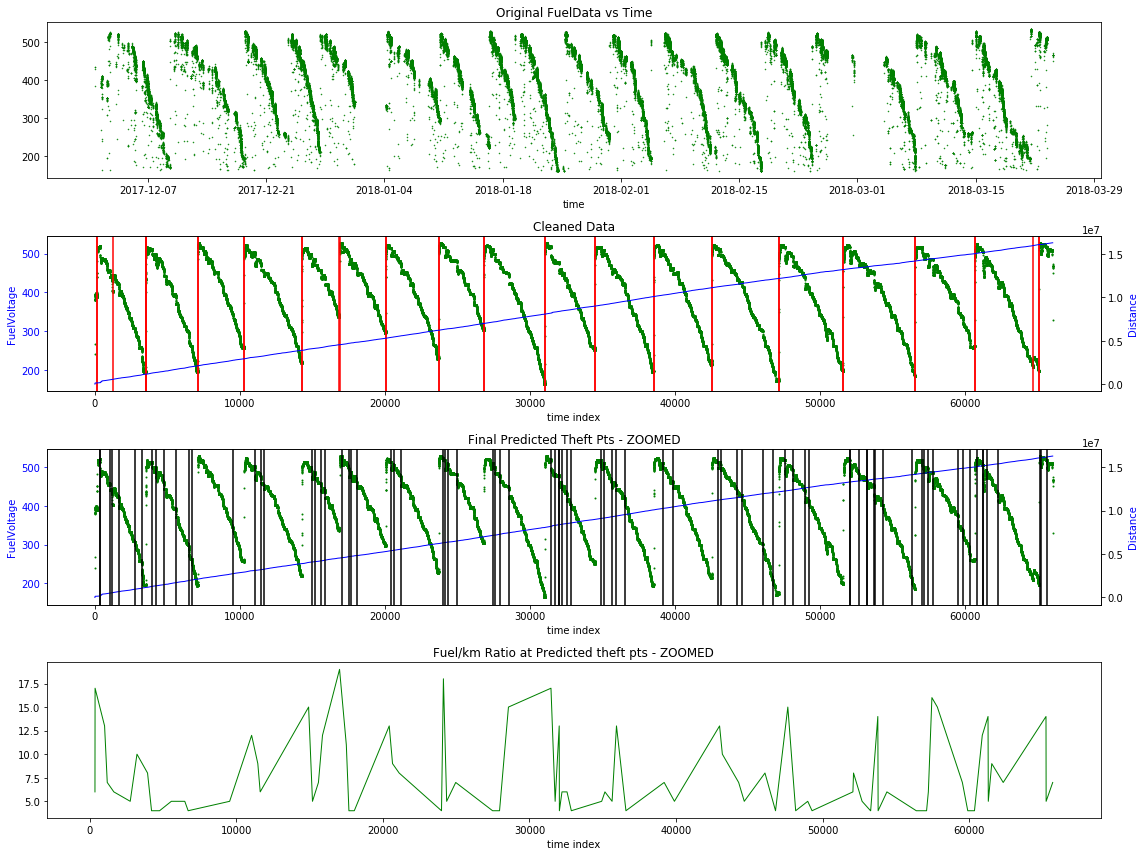

In [118]:
#build_savePath = savePath + r"\result_dataset_" + filesname[ctr].replace(folderpath,"").replace('\\', "")
#result_df.to_csv(build_savePath)
%matplotlib inline
plot_Results(dff,df_clean2, theft_df, theft_pts, refuel_df['refuel_index'] , xlim = [], ylim1=ylim);
#ctr+=1
#print(refuel_df)

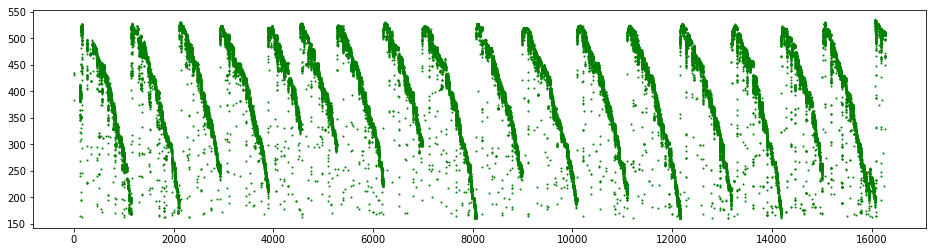

In [119]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(df_clean.distance*0.001, df_clean.fuelVoltage, 'g.', markersize = 2)

In [ ]:
def findAVG(cleanDf, Dmax):
    i = 0
    ds = 0
    df = 0
    dsRef = 0
    dt = 10000
    avgdt_lst = []
    mean_lst = []
    median_lst = []
    indexlst_lst = []
    ctr = 0
    df1 = 0
    print(Dmax)
    while dt < 30000:
        avgDT = []
        indexlst = []
        #print (dt)
        i=0
        while i<len(cleanDf): 
            ds = 0
            df1 = 0
            dsRef = cleanDf.distance[i]
            dfRef = cleanDf.fuelVoltage[i]
            while ((ds)<=dt  and i<len(cleanDf)):
                ds = (cleanDf.distance[i] - dsRef)
                i+=1
                #print(i)

            if i<len(cleanDf):
                df = dfRef- cleanDf.fuelVoltage[i]
                if df>0 :
                    avg = df/ds
                    avgDT.append(avg)
                    indexlst.append(cleanDf.index[i])
            
            #print(df)
        indexlst_lst.append(indexlst)
        avgdt_lst.append(avgDT)
        med = pd.Series(avgDT).median()
        mean = pd.Series(avgDT).mean()
        #print (med,mean,mode)

        median_lst.append(med)
        mean_lst.append(mean)
        ctr+=1
        dt += 1000
        print (dt)

        
    return [median_lst,mean_lst], avgdt_lst, indexlst_lst

central_DT, avgLst, indexlst = findAVG(df_clean, Dmax)

In [ ]:
len(df_clean), len(avgLst), len(indexlst)

In [ ]:
#dt = [i*100 for (i,dt) in zip(len(central_DT[0]),Dmax) ]
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.hist(central_DT[0],bins =100);
plt.grid()
plt.axvline(pd.Series(central_DT[0]).mean(), color = 'black')
plt.axvline(pd.Series(central_DT[0]).median(), color = 'yellow')
plt.axvline(pd.Series(central_DT[0]).median() + 2*pd.Series(central_DT[0]).std(), color = 'Red')

#plt.ylim(0,.005)
plt.subplot(3,1,2)
plt.plot(central_DT[1]);
plt.ylim(0,.001)
plt.grid()
plt.title("Median dF/dS vs Increasing Ds")

#plt.plot(central_DT[2]);

        

In [ ]:
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.plot(avgLst[1],'b-');
plt.grid()
#plt.ylim(0,.4)

plt.axhline(pd.Series(avgLst[1]).mean(), color = 'black')
plt.axhline(pd.Series(avgLst[1]).median(), color = 'green')
plt.axhline(2*pd.Series(avgLst[1]).std(), color = 'Red')
#plt.xlim(0,500)
plt.subplot(3,1,2)
plt.plot(avgLst[0], 'b-');
plt.axhline(pd.Series(avgLst[0]).mean(), color = 'black')
plt.axhline(pd.Series(avgLst[0]).median(), color = 'green')
plt.axhline(2*pd.Series(avgLst[0]).std(), color = 'Red')

#plt.ylim(0,.4)
plt.grid()

In [ ]:
(indexlst[0])

In [ ]:
plt.hist(avgLst[1][abs(avgLst[1] - avgLst[1].mean()) < 3*avgLst[1].std()],bins = 200)
plt.axvline(avgLst[1].median(), color = 'black')
plt.axvline(avgLst[1].mean(), color = 'green')

In [ ]:

# w = IntSlider()
# display(w)
def f(x):
    return x
interact(f, x= IntSlider(min=-10, max=30, step=1,value=1));

In [ ]:
def f(x):    
    index = indexlst[x]
    avg = avgLst[x]
    plt.rcParams['figure.figsize'] = [16,4]
    plt.plot(index, avg, 'g.', markersize = 2)
    plt.axhline(pd.Series(avg).median(), color = 'red')
    plt.axhline(pd.Series(avg).mean(), color = 'blue')
    plt.axhline(pd.Series(avg).median() + 2*pd.Series(avg).std(), color = 'Black')
    plt.ylim(0,0.002)

interact(f, x= IntSlider(min=0, max=20, step=1,value=10));

In [ ]:
def findAVG2(cleanDf, Dmax):
    i = 0
    ds = 0
    df = 0
    dsRef = 0
    dt = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/500
    dtmax = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/50
    avgdt_lst = []
    mean_lst = []
    median_lst = []
    indexlst_lst = []
    ctr = 0
    df1 = 0
    print(Dmax, dt, dtmax)
    while dt < dtmax:
        avgDT = []
        indexlst = []
        print ("dt = ",dt)
        i=0
        while i<len(cleanDf): 
            df = 0
            dfRef = cleanDf.fuelVoltage[i]
            dsRef = cleanDf.distance[i]
            while (df<=dt  and i<len(cleanDf)):
                df = dfRef - cleanDf.fuelVoltage[i] 
                if df <0 :
                    dfRef = cleanDf.fuelVoltage[i]
                i+=1
                #print(i)
            
            if i<len(cleanDf):
                ds = cleanDf.distance[i] - dsRef
                if df>0 :
                    #print (i)
                    if ds==0:
                        ds = df/1000
                        print("df = ",df,"****",i)
                    avg = df/ds
                    avgDT.append(avg)
                    indexlst.append(cleanDf.index[i])
            
        #print(avgDT)
        #print(dt)
        indexlst_lst.append(indexlst)
        if len(avgDT)!=0 :
            avgdt_lst.append(avgDT)
            med = pd.Series(avgDT).median()
            mean = pd.Series(avgDT).mean()
            #print (med,mean,mode)

            median_lst.append(med)
            mean_lst.append(mean)
        ctr+=1
        dt += dtmax/100
        #print (dt)

        
    return [median_lst,mean_lst], avgdt_lst, indexlst_lst

central_DT2, avgLst2, indexlst2 = findAVG2(df_clean, Dmax)

In [ ]:
def findMax_decayRate(cleanDf):

    i = 0
    dt = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/500
    avgDT = []
    indexlst = []
    
    while i<len(cleanDf): 
        df = 0
        dfRef = cleanDf.fuelVoltage[i]
        dsRef = cleanDf.distance[i]
        while (df<=dt  and i<len(cleanDf)):
            df = dfRef - cleanDf.fuelVoltage[i] 
            if df <0 :
                dfRef = cleanDf.fuelVoltage[i]
            i+=1
            #print(i)

        if i<len(cleanDf):
            ds = cleanDf.distance[i] - dsRef
            if df>0 :
                #print (i)
                if ds==0:
                    ds = df/1000
                    #print("df = ",df,"****",i)
                avg = df/ds
                avgDT.append(avg)
                indexlst.append(cleanDf.index[i])

        med = pd.Series(avgDT).median()
        mean = pd.Series(avgDT).mean()
        avg = pd.Series(avgDT)
        max_dCRate = avg.median()+ 3*abs(avg - avg.median()).median()
        
    return pd.Series(avgDT), indexlst, max_dCRate

avgDT, indexlst, max_dCRate = findMax_decayRate(df_clean)

In [ ]:
len(df_clean), len(avgDT), len(indexlst), max_dCRate

In [ ]:
sum(avgDT==1000)

In [ ]:
#dt = [i*100 for (i,dt) in zip(len(central_DT[0]),Dmax) ]
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.hist(central_DT2[0],bins =100);
plt.grid()
plt.axvline(pd.Series(central_DT2[0]).mean(), color = 'black')
plt.axvline(pd.Series(central_DT2[0]).median(), color = 'yellow')
plt.axvline(pd.Series(central_DT2[0]).median() + 2*pd.Series(central_DT2[0]).std(), color = 'Red')
plt.title('Histogram plot for Average Median for Varying Windows size')

plt.subplot(3,1,2)
plt.hist(central_DT2[1],bins =1000);
plt.grid()
plt.axvline(pd.Series(central_DT2[1]).mean(), color = 'black')
plt.axvline(pd.Series(central_DT2[1]).median(), color = 'yellow')
plt.axvline(pd.Series(central_DT2[1]).median() + 2*pd.Series(central_DT2[1]).std(), color = 'Red')
plt.semilogx()
plt.semilogy()
plt.ylim(0,5000)
plt.title('Average Mean plot for Varying Windows size')

plt.subplot(3,1,3)
plt.plot(central_DT2[0]);
#plt.ylim(0,.002)
plt.grid()
plt.title("Median dF/dS vs Increasing Ds")

In [ ]:
def f2(x):
    return x
def f(x):    
    index = indexlst2[x]
    avg = avgLst2[x]
    avg = pd.Series(avg)
    plt.rcParams['figure.figsize'] = [16,8]
    interact(f2, x=str(pd.Series(avg).median()));
    interact(f2, x=str(pd.Series(avg).median()+ 3*abs(avg - avg.median()).median()));
    plt.subplot(2,1,1)
    plt.plot(index, avg, 'g.')
    plt.semilogy()
    plt.axhline(pd.Series(avg).median(), color = 'red')
    plt.axhline(pd.Series(avg).median() + 2*pd.Series(avg).std(), color = 'Black')
    plt.axhline(pd.Series(avg).median()+ 4*abs(avg - avg.median()).median(), color = 'Blue')
    plt.axhline(pd.Series(avg).median()- 2*abs(avg - avg.median()).median(), color = 'Blue')
    abs(avg - avg.median()).median()
   # plt.ylim(0,0.05)
    plt.subplot(2,1,2)
    plt.plot(index,avg)
    plt.semilogy()
    plt.semilogx()
    #plt.ylim(0,0.1)
    #plt.axhline(pd.Series(avg).median(), color = 'red')
   # plt.axhline(pd.Series(avg).mean(), color = 'blue')
   ## plt.axhline(pd.Series(avg).median() + 2*pd.Series(avg).std(), color = 'Black')
    
    
interact(f, x= IntSlider(min=0, max=200, step=1,value=0));


In [ ]:
IntProgress(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

In [ ]:
 avg = pd.Series(avgLst2[0])
abs(avg - avg.median()).median()

In [ ]:
avg[avg!=1000].median(), avg[avg!=1000].std()

In [ ]:
meddev = []
for  avg in avgLst2:
    avg = pd.Series(avg)
    meddev.append(pd.Series(avg).median()+ 2*abs(avg - avg.median()).median())
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(meddev)
plt.axhline(pd.Series(meddev).median(), color = 'red')
plt.axhline(pd.Series(meddev).mean(), color = 'Black')
plt.xlim(0,100)

In [ ]:
pd.Series(meddev).mean(), max(meddev)

In [ ]:
a = avgDT.value_counts()
avgDT.median(), avgDT.mean(), avgDT.mode()

10km:
mean = 0.0167
median = 0.0131
mode = 0.0037

1km:
mean = 0.0095
median = 0.00562
mode = 0.00187

5km:
mean = 0.00138
median = 0.00936
mode = 0.00187

0.5Km
mean = 0.00138
median = 0.00936
mode = 0.00187

50km
mean = 0.0373
median = 0.0365
mode = 0.0411

100km
mean = 0.065988
median = 0.0692
mode = 0.048689









In [ ]:
plt.plot(df_clean.distance * .001*Dmax, df_clean.fuelVoltage,  'g.')

In [ ]:
from numpy import arange, sin, pi, float, size

import matplotlib
matplotlib.use('WXAgg')
from matplotlib.backends.backend_wxagg import FigureCanvasWxAgg
from matplotlib.figure import Figure

import wxpython as wx

class MyFrame(wx.Frame):
    def __init__(self, parent, id):
        wx.Frame.__init__(self,parent, id, 'scrollable plot',
                style=wx.DEFAULT_FRAME_STYLE ^ wx.RESIZE_BORDER,
                size=(800, 400))
        self.panel = wx.Panel(self, -1)

        self.fig = Figure((5, 4), 75)
        self.canvas = FigureCanvasWxAgg(self.panel, -1, self.fig)
        self.scroll_range = 400
        self.canvas.SetScrollbar(wx.HORIZONTAL, 0, 5,
                                 self.scroll_range)

        sizer = wx.BoxSizer(wx.VERTICAL)
        sizer.Add(self.canvas, -1, wx.EXPAND)

        self.panel.SetSizer(sizer)
        self.panel.Fit()

        self.init_data()
        self.init_plot()

        self.canvas.Bind(wx.EVT_SCROLLWIN, self.OnScrollEvt)

    def init_data(self):

        # Generate some data to plot:
        self.dt = 0.01
        self.t = arange(0,5,self.dt)
        self.x = sin(2*pi*self.t)

        # Extents of data sequence: 
        self.i_min = 0
        self.i_max = len(self.t)

        # Size of plot window:       
        self.i_window = 100

        # Indices of data interval to be plotted:
        self.i_start = 0
        self.i_end = self.i_start + self.i_window

    def init_plot(self):
        self.axes = self.fig.add_subplot(111)
        self.plot_data = \
                  self.axes.plot(self.t[self.i_start:self.i_end],
                                 self.x[self.i_start:self.i_end])[0]

    def draw_plot(self):

        # Update data in plot:
        self.plot_data.set_xdata(self.t[self.i_start:self.i_end])
        self.plot_data.set_ydata(self.x[self.i_start:self.i_end])

        # Adjust plot limits:
        self.axes.set_xlim((min(self.t[self.i_start:self.i_end]),
                           max(self.t[self.i_start:self.i_end])))
        self.axes.set_ylim((min(self.x[self.i_start:self.i_end]),
                            max(self.x[self.i_start:self.i_end])))

        # Redraw:                  
        self.canvas.draw()

    def OnScrollEvt(self, event):

     # Update the indices of the plot:
        self.i_start = self.i_min + event.GetPosition()
        self.i_end = self.i_min + self.i_window + event.GetPosition()
        self.draw_plot()

class MyApp(wx.App):
    def OnInit(self):
        self.frame = MyFrame(parent=None,id=-1)
        self.frame.Show()
        self.SetTopWindow(self.frame)
        return True

if __name__ == '__main__':
    app = MyApp()
    app.MainLoop()